# Forecasting in statsmodels

Questo notebook descrive le previsioni utilizzando modelli di serie temporali in statsmodels.

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#importing dataset
australia = pd.read_csv('AUS.csv', header = 0)

new_names = {'Date': 'date', 'Location': 'location','MinTemp': 'min_temp', 
            'MaxTemp': 'max_temp', 'Rainfall':'rainfall', 'Evaporation': 'evaporation', 'Sunshine': 'sunshine', 
            'WindGustDir':'wind_gust_dir', 'WindGustSpeed': 'wind_gust_speed', 'WindDir9am': 'wind_dir_9am', 'WindDir3pm': 'wind_dir_3pm',
            'WindSpeed9am': 'wind_speed_9am', 'WindSpeed3pm': 'wind_speed_3pm',
            'Humidity9am':'humidity_9am', 'Humidity3pm':'humidity_3pm', 'Pressure9am':'pressure_9am', 'Pressure3pm':'pressure_3pm',
            'Cloud9am':'cloud_9am', 'Cloud3pm':'cloud_3pm', 'Temp9am':'temp_9am', 'Temp3pm':'temp_3pm',
            'RainToday': 'rain_today', 'RainTomorrow': 'rain_tomorrow' }
australia.rename(columns=new_names, inplace=True)
australia = australia.drop(['sunshine','evaporation'], axis=1)

#correzione del campo wind_dir e wind_speed: mettiamo 0 al posto di null ai campi dir se la velocità del vento è 0 (non c'è vento in quel momento)
australia['wind_dir_9am'] = australia[['wind_dir_9am','wind_speed_9am']].apply(lambda x: '0' if x['wind_speed_9am']==0 else x['wind_dir_9am'], axis=1)
australia['wind_dir_3pm'] = australia[['wind_dir_3pm','wind_speed_3pm']].apply(lambda x: '0' if x['wind_speed_3pm']==0 else x['wind_dir_3pm'], axis=1)

# rimuoviamo i gust perchè sono presi dalle colonne sopra, tra il massimo della giornata
australia = australia.drop(['wind_gust_dir','wind_gust_speed'], axis=1)

#togliamo tutte quelle città che hanno almeno il 40% di null sul campo cloud3pm
location = australia.location.unique()
#print(location)
count = 0
for loc in location:
    #print(loc, len(australia[australia['location']==loc]))
    lung = len(australia[australia['location']==loc])
    if australia[australia['location']==loc].isnull().sum().cloud_3pm > lung * 0.4:
        australia = australia.drop(australia[australia['location'] == loc].index)
        count +=1

australia = australia.dropna(thresh = 16)
australia = australia.ffill(axis=0)

#aggiungiamo la colonna state in funzione della città 

#stati:
sa = ['Adelaide', 'MountGambier', 'Nuriootpa', 'Woomera'] #australia meridionale
wa = ['Albany', 'Witchcliffe', 'PearceRAAF', 'PerthAirport', 'Perth', 'SalmonGums',
      'Walpole'] #australia occidentale
nsw = ['Albury', 'BadgerysCreek', 'Cobar', 'CoffsHarbour', 'Moree',
       'Newcastle', 'NorahHead', 'Penrith', 'Richmond', 'Sydney', 'SydneyAirport',
       'WaggaWagga', 'Williamtown', 'Wollongong'] #Nuovo Galles del Sud
qld = ['Brisbane', 'Cairns', 'GoldCoast', 'Townsville'] #Queensland
tas = ['Hobart', 'Launceston'] #Tasmania
vic = ['Ballarat', 'Bendigo', 'Sale', 'Melbourne', 'MelbourneAirport',
      'Mildura', 'Nhil', 'Portland', 'Watsonia', 'Dartmoor'] #Victoria
act = ['Camberra', 'Tuggeranong', 'MountGinini'] #territorio della capitale australiana
nt = [ 'AliceSprings', 'Darwin', 'Katherine', 'Uluru'] #Territorio del nord
nfk = ['NorfolkIsland'] #territorio esterno del norfolk
 
#gli ultimi quattro si potrebbero unire anche in un unico territorio del sud est australiano,
#a livello di clima dovrebbero essere molto simii potrebbe avere difficoltà a classificarli

def State(a):
    if a in sa:
        return 'SA'
    elif a in wa:
        return 'WA'
    elif a in nsw:
        return 'NSW'
    elif a in qld:
        return 'QLD'
    elif a in tas:
        return 'TAS'
    elif a in vic:
        return 'VIC'
    elif a in act:
        return 'ACT'
    elif a in nt:
        return 'NT'
    elif a in nfk:
        return 'NFK'
    

#le = preprocessing.LabelEncoder()
#crime['category_id'] = le.fit_transform(australia['state'])

australia['state'] = australia.location.apply(lambda x: str(State(x)))


In [2]:
australia.head()

,date,location,min_temp,max_temp,rainfall,wind_dir_9am,wind_dir_3pm,wind_speed_9am,wind_speed_3pm,humidity_9am,humidity_3pm,pressure_9am,pressure_3pm,cloud_9am,cloud_3pm,temp_9am,temp_3pm,rain_today,rain_tomorrow,state
6049,2009-01-01,Cobar,17.9,35.2,0.0,ENE,SW,6.0,20.0,20.0,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,No,No,NSW
6050,2009-01-02,Cobar,18.4,28.9,0.0,SSE,SSE,19.0,19.0,30.0,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,No,No,NSW
6052,2009-01-04,Cobar,19.4,37.6,0.0,NNE,NNW,30.0,15.0,42.0,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,No,No,NSW
6053,2009-01-05,Cobar,21.9,38.4,0.0,WNW,WSW,6.0,6.0,37.0,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,No,No,NSW
6054,2009-01-06,Cobar,24.2,41.0,0.0,NW,WNW,17.0,13.0,19.0,15.0,1010.7,1007.4,1.0,6.0,33.6,37.6,No,No,NSW


Manteniamo per il forecasting tutte e sole le città sul mare

In [3]:
vec = ['CoffsHarbour', 'Newcastle', 'Sydney', 'SydneyAirport', 
    'Canberra', 'Williamtown', 'Ballarat', 'Sale', 'MelbourneAirport', 'Melbourne',
    'Portland', 'Watsonia', 'Brisbane', 'Cairns', 'Townsville', 'MountGambier']
    
aus1 = australia[australia.location.isin(vec)]

In [4]:
aus2 = aus1.drop(['wind_dir_9am', 'wind_dir_3pm', 'wind_speed_9am', 'humidity_9am', 'pressure_9am', 'rain_tomorrow', 'state', 'temp_9am'], axis=1)

In [5]:
aus2['date'] = pd.to_datetime(aus2['date'])
#aus2['month'] = aus2['date'].dt.month

In [6]:
aus2 = aus2.reset_index()
aus2 = aus2.drop(["index"], axis = 1)
#australia.head()
aus2.tail()

,date,location,min_temp,max_temp,rainfall,wind_speed_3pm,humidity_3pm,pressure_3pm,cloud_9am,cloud_3pm,temp_3pm,rain_today
46744,2017-06-21,MountGambier,8.7,13.2,2.0,11.0,82.0,1028.3,8.0,8.0,12.0,Yes
46745,2017-06-22,MountGambier,7.0,15.7,0.0,15.0,67.0,1022.4,8.0,8.0,14.9,No
46746,2017-06-23,MountGambier,5.4,16.2,0.0,24.0,70.0,1014.4,8.0,4.0,14.9,No
46747,2017-06-24,MountGambier,4.8,12.3,2.2,15.0,70.0,1018.0,5.0,8.0,11.5,Yes
46748,2017-06-25,MountGambier,6.4,12.3,0.6,19.0,84.0,1016.2,8.0,8.0,12.2,No


## Basic example

Un semplice esempio è quello di utilizzare un modello AR(1) per prevedere l'inflazione. Prima di fare previsioni, diamo un'occhiata alla serie:

In [7]:
aus3= aus2[aus2['location'] == 'Sydney']
aus3 = aus3.set_index('date')
aus3.head()

,location,min_temp,max_temp,rainfall,wind_speed_3pm,humidity_3pm,pressure_3pm,cloud_9am,cloud_3pm,temp_3pm,rain_today
date,,,,,,,,,,,
2008-02-01,Sydney,19.5,22.4,15.6,20.0,84.0,1017.4,8.0,8.0,20.9,Yes
2008-02-02,Sydney,19.5,25.6,6.0,13.0,73.0,1016.4,7.0,7.0,24.8,Yes
2008-02-03,Sydney,21.6,24.5,6.6,2.0,86.0,1015.6,7.0,8.0,23.0,Yes
2008-02-04,Sydney,20.2,22.8,18.8,20.0,90.0,1011.8,8.0,8.0,20.9,Yes
2008-02-05,Sydney,19.7,25.7,77.4,6.0,74.0,1004.8,8.0,8.0,25.5,Yes


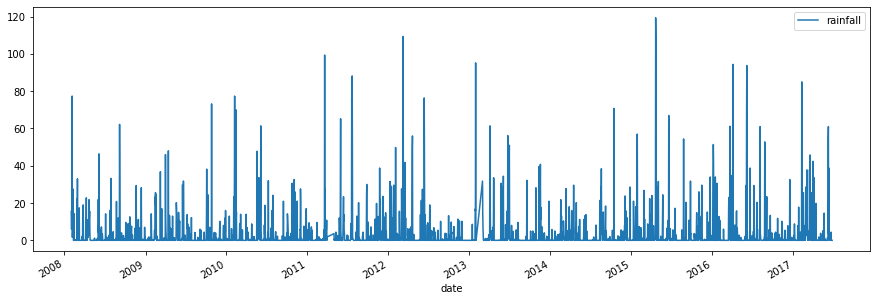

In [8]:
endog = aus3['rainfall']
for loc in aus3['location'].unique():
    tmp = aus3[aus3.location == loc]
    tmp.plot( y ='rainfall', figsize=(15, 5))

# STATIONARY TEST

##### KPSS Test

In [9]:
from statsmodels.tsa.stattools import kpss
kpss_test(aus3['rainfall'].dropna())

NameError: name 'kpss_test' is not defined

##### ADF Test

In [10]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(aus3.rainfall.dropna())

print('ADF Statistic: %f' %result[0])
print('p-value: %f' % result[1])

ADF Statistic: -40.795366
p-value: 0.000000


##### Phillips-Perron Testing

In [11]:
from arch.unitroot import PhillipsPerron

pp = PhillipsPerron(aus3.rainfall)
print(pp.summary().as_text())

ModuleNotFoundError: No module named 'arch'

La serie stazionaria se p-value < 0.05 
> d = 0

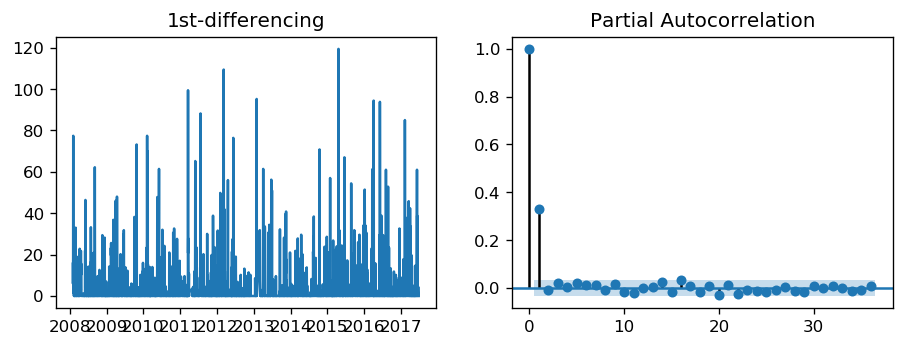

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize' :(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1,2)
axes[0].plot(aus3.rainfall); axes[0].set_title('1st-differencing')
#axes[1].set(ylim=(-0,0.2))
plot_pacf(aus3.rainfall.dropna(), ax=axes[1])

plt.show()

il valore per noi interessante è p=1 poichè è quello che esce dall'area di significatività in modo evidente e impatta maggiormente sul valore attuale rispetto tutti gli altri.
> p = 1

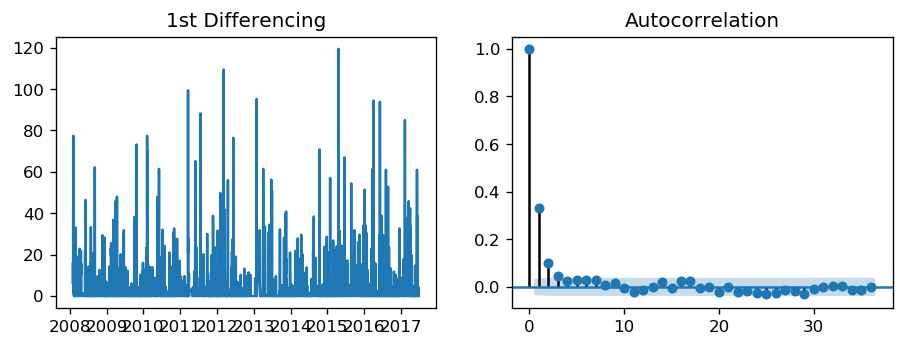

In [13]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize': (9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)
axes[0].plot(aus3.rainfall); axes[0].set_title('1st Differencing')
#axes[1].set(xlim=(0,4))
plot_acf(aus3.rainfall.dropna(), ax=axes[1])

plt.show()

Il valore per noi interessante è q=1 poichè è quello che esce dall'area di significatività in modo evidente e impatta maggiormente sul valore attuale rispetto tutti gli altri. 

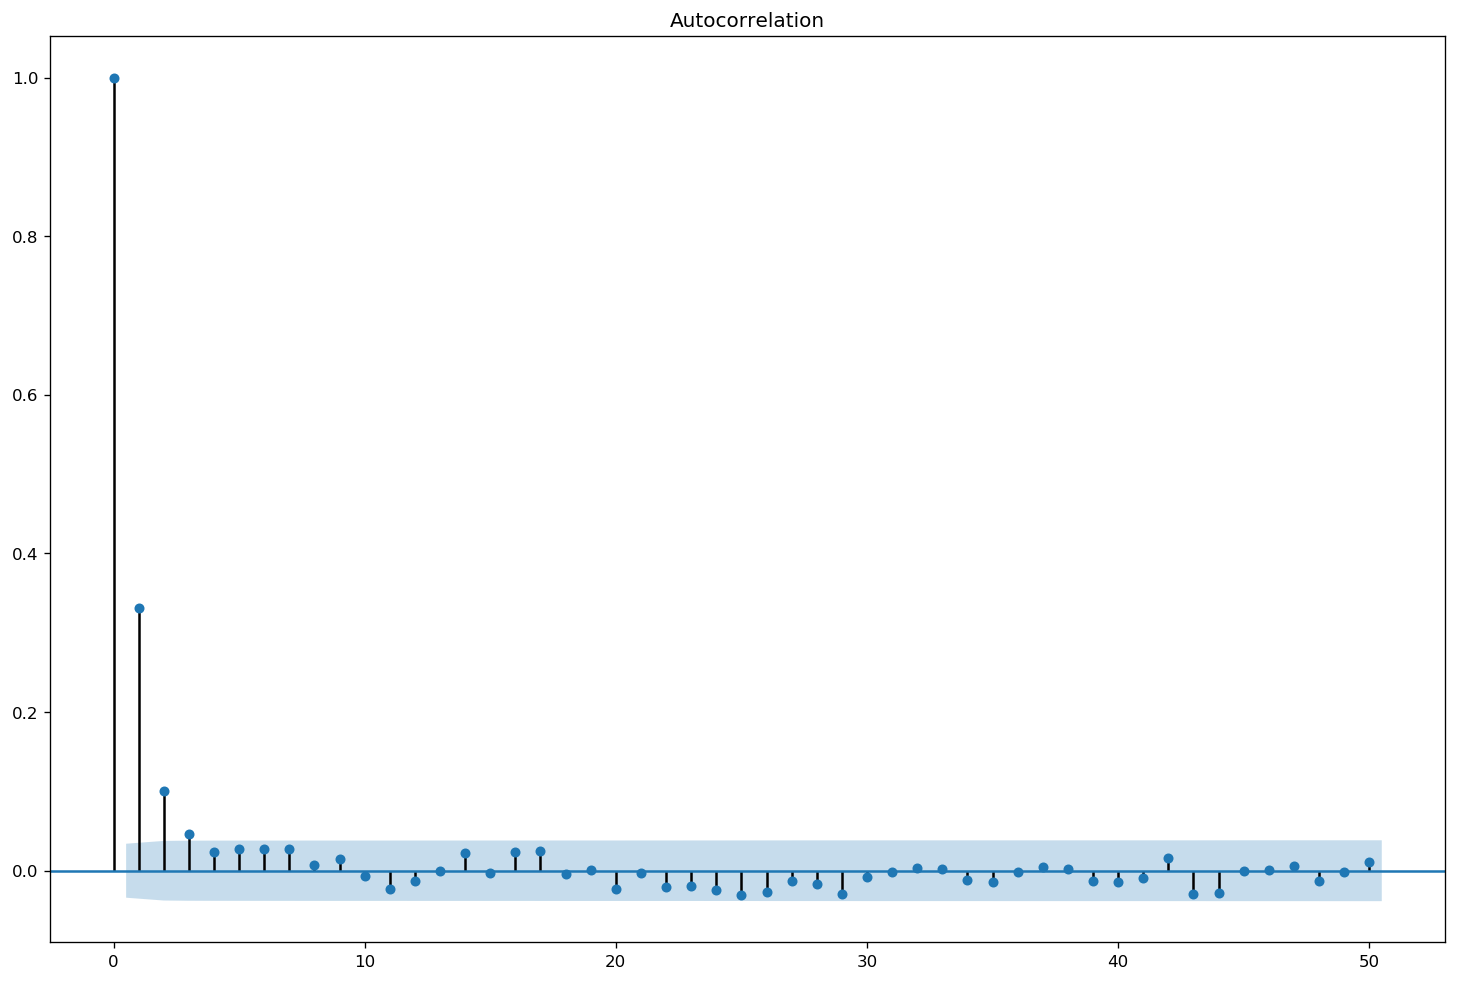

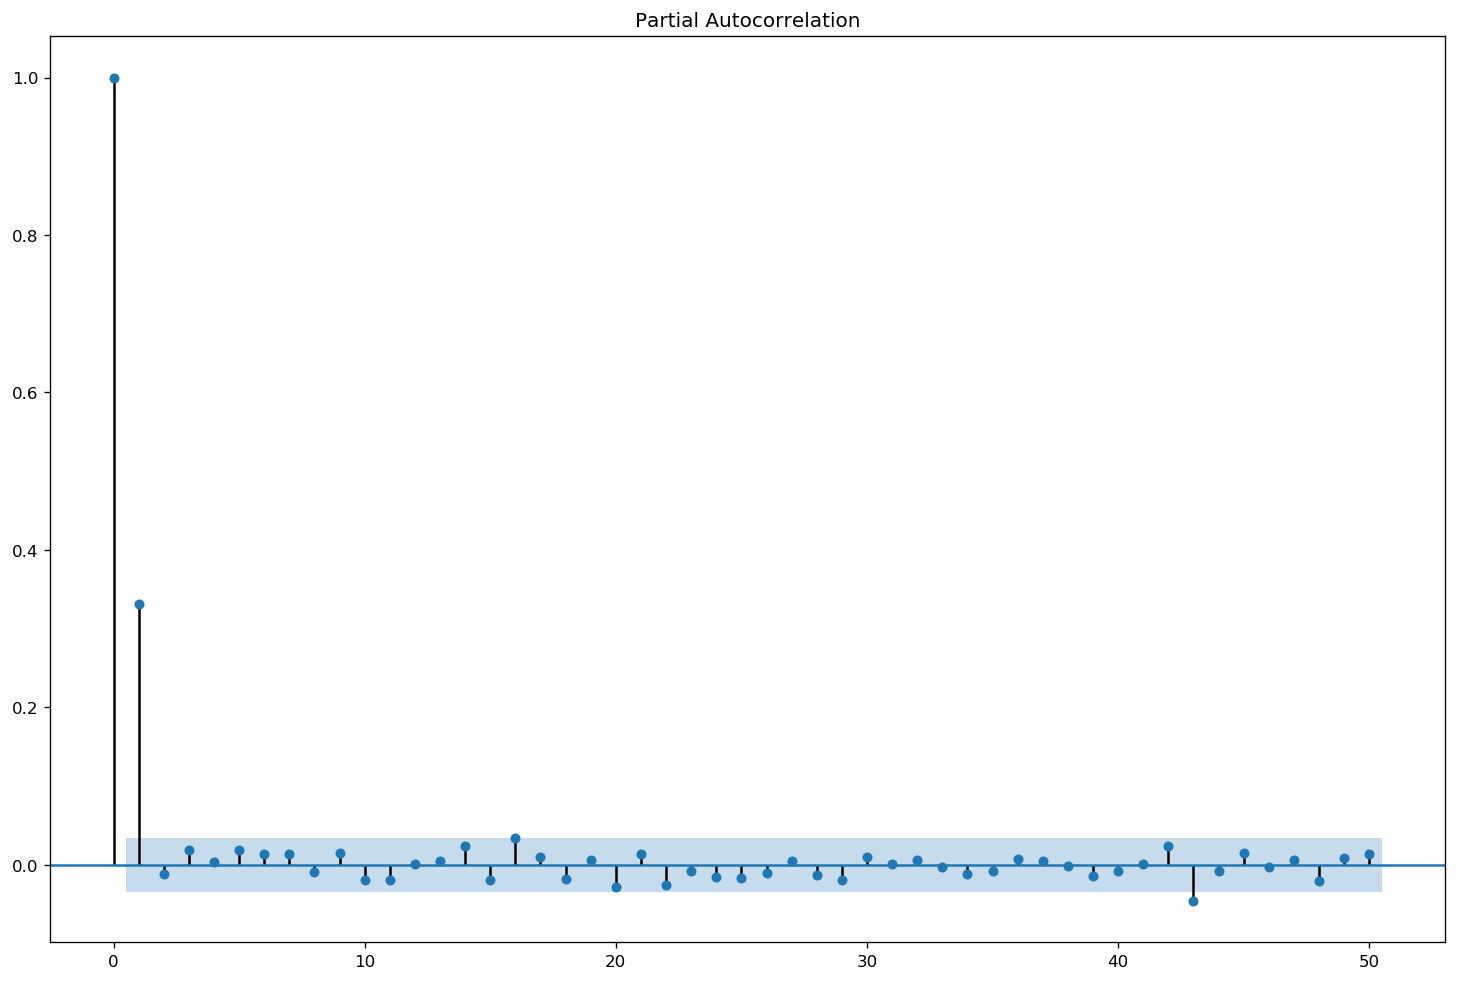

In [14]:
f_acf = plot_acf(aus3.rainfall, lags=50)
f_pacf = plot_pacf(aus3.rainfall, lags=50, method='ywunbiased')
f_acf.set_figheight(10)
f_acf.set_figwidth(15)
f_pacf.set_figheight(10)
f_pacf.set_figwidth(15)
plt.show()

### Constructing and estimating the model
### Arima

In [15]:
from statsmodels.tsa.arima_model import ARIMA

# Construct the model
model = ARIMA(aus3.rainfall, order=(1, 1, 1)) # p, d, q
# Estimate the parameters
model_fit1 = model.fit(disp = 0)

print(model_fit1.summary())

                             ARIMA Model Results                              
Dep. Variable:             D.rainfall   No. Observations:                 3315
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -12114.129
Method:                       css-mle   S.D. of innovations              9.340
Date:                Fri, 05 Feb 2021   AIC                          24236.258
Time:                        14:19:19   BIC                          24260.683
Sample:                             1   HQIC                         24244.999
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0003      0.000      1.106      0.269      -0.000       0.001
ar.L1.D.rainfall     0.3314      0.016     20.212      0.000       0.299       0.364
ma.L1.D.rainfall    -1.0000 

### ARIMAX

In [16]:
from statsmodels.tsa.arima_model import ARIMA

# Construct the model
model = ARIMA(aus3.rainfall, exog= aus3.humidity_3pm, order=(1, 0, 1)) # p, d, q
# Estimate the parameters
model_fit2 = model.fit(disp = 0)

print(model_fit2.summary())

                              ARMA Model Results                              
Dep. Variable:               rainfall   No. Observations:                 3316
Model:                     ARMA(1, 1)   Log Likelihood              -12048.498
Method:                       css-mle   S.D. of innovations              9.157
Date:                Fri, 05 Feb 2021   AIC                          24106.996
Time:                        14:19:20   BIC                          24137.528
Sample:                             0   HQIC                         24117.922
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -3.9358      0.655     -6.006      0.000      -5.220      -2.651
humidity_3pm       0.1328      0.011     11.699      0.000       0.111       0.155
ar.L1.rainfall     0.2222      0.070

In [ ]:
# se numero di stagionalità > 0 --> P > 0
# se serie è stazionaria --> D = 1 altrimenti D = 0
# se numero di stagionalità > 0 --> Q = 0
# P + Q <= 2
# --> scegliamo P = D = 1, Q = 0; la nostra stagionalità è annuale, in teoria dovremmo mettere il n° delle righe che
#costituiscono un anno

from statsmodels.tsa.statespace.sarimax import SARIMAX

# Construct the model
mod = SARIMAX(aus3.rainfall, order=(1, 0, 1), trend='c', seasonal_order=(1, 1, 0, 365))
# Estimate the parameters
res = mod.fit()

print(res.summary())

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing #HWES

model = ExponentialSmoothing(aus3.rainfall)
model_fit3 = model.fit()

print(model_fit3.summary())

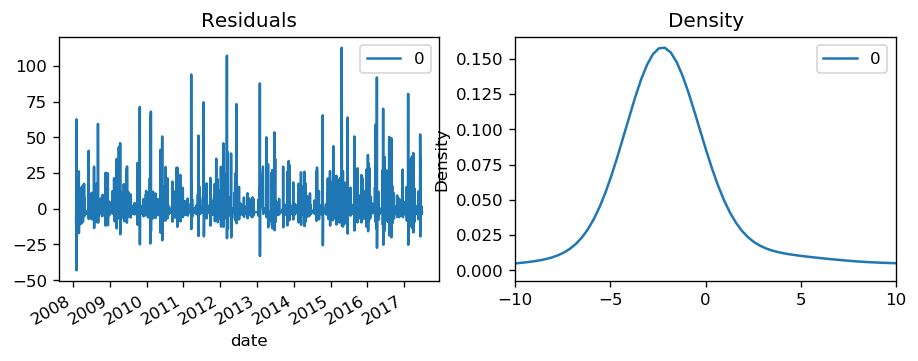

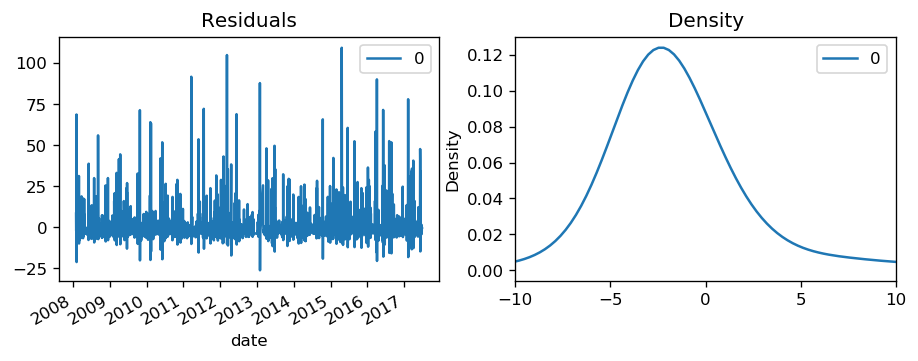

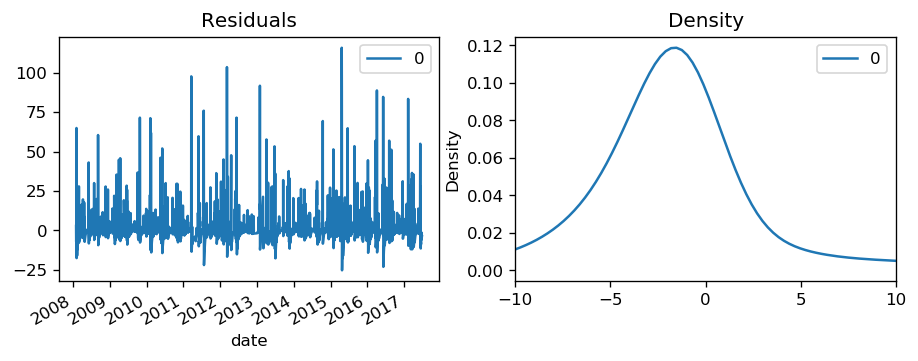

In [21]:
residuals = pd.DataFrame(model_fit1.resid)
rig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
ax[1].set(xlim=(-10,10))
plt.show()

residuals = pd.DataFrame(model_fit2.resid)
rig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
ax[1].set(xlim=(-10,10))
plt.show()

residuals = pd.DataFrame(model_fit3.resid)
rig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
ax[1].set(xlim=(-10,10))
plt.show()

la media dei residui è nulla, ma come possiamo notare ci sono dei picchi pronunciati verso i valori positivi

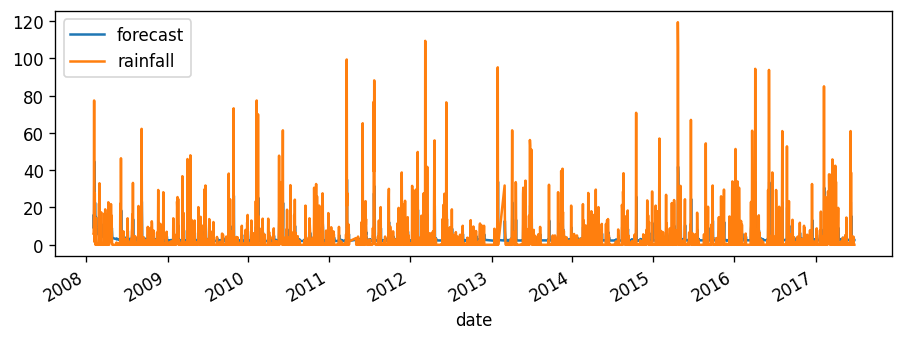

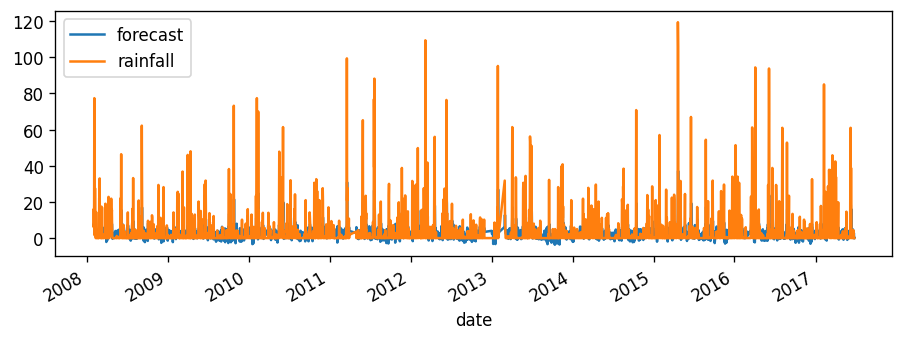

In [166]:
model_fit1.plot_predict(dynamic=False)
plt.show()

model_fit2.plot_predict(dynamic=False)
plt.show()

In [140]:
from statsmodels.tsa.stattools import acf

l = int(len(aus3)*0.75)
train = aus3.rainfall[:l]
test = aus3.rainfall[l:]
print(l, len(aus3)-l)

2487 829


In [138]:
from sklearn.model_selection import KFold # import KFold

x = aus3.rainfall
kf = KFold(n_splits = 4) # Define the split - into 2 folds 
kf.get_n_splits(x) # returns the number of splitting iterations in the cross-validator


for train_index, test_index in kf.split(x):
    #print('TRAIN:', train_index, 'TEST: ', test_index)
    X_train, X_test = x[train_index], x[test_index]
print(len(X_train), len(X_test))

2487 829


C:\Users\angel\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\angel\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\angel\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


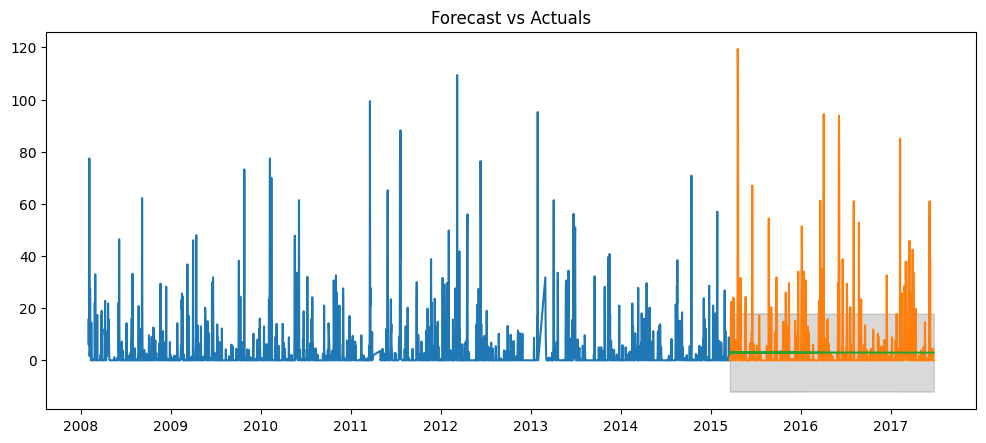

In [185]:
model = ARIMA(train, order=(2,1,2))
fitted = model.fit(disp=-1)

#forecast
fc,se, conf = fitted.forecast(829, alpha=0.1) #95% conf

#make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:,0], index=test.index)
upper_series = pd.Series(conf[:,1], index=test.index)

#plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')

plt.fill_between(lower_series.index, lower_series, upper_series,color='k', alpha=.15)
plt.title('Forecast vs Actuals')
#plt.legend(loc='uooer keft', fitsize=8)
plt.show()


In [186]:
def forecast_accuracy(forecast, actual):
    mape= np.mean(np.abs(forecast - actual)/np.abs(actual)) #MAPE
    me = np.mean(forecast - actual) #ME
    mae= np.mean(np.abs(forecast - actual)) #MAE
    mpe = np.mean((forecast - actual)/actual) #MPE
    rmse= np.mean((forecast - actual)**2)**.5 #RMSE
    corr = np.corrcoef(forecast, actual)[0,1] #Corr
    mins = np.amin(np.hstack([forecast[:,None], actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], actual[:,None]]), axis=1)
    
    minmax = 1- np.mean(mins/maxs)
    acf1 = acf(fc-test)[1]
    return({'mape': mape, 'me': me, 'mae':mae, 'mpe':mpe, 'rmse':rmse, 'acf1':acf1, 'corr': corr, 'minmax':minmax})
    
forecast_accuracy(fc, test.values)
    

{'mape': inf,
 'me': -1.0744029756372744,
 'mae': 5.4308380523312305,
 'mpe': inf,
 'rmse': 12.068958614330809,
 'acf1': 0.3724609526395737,
 'corr': 0.003981105464146793,
 'minmax': 0.8655408889203712}

# FINE

### Forecasting

Le previsioni out-of-sample sono prodotte usando i metodi `forecast` o `get_forecast` dall'oggetto rappresentante il modello.

Il metodo `forecast` fornisce solo previsioni puntuali.

In [55]:
# The default is to get a one-step-ahead forecast:
print(res.forecast())

3316    2.235147
dtype: float64


C:\Users\angel\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


Il metodo `get_forecast` è più generale e permette anche di costruire intervalli di confidenza.

In [56]:
# Here we construct a more complete results object.
fcast_res1 = res.get_forecast()

# Most results are collected in the `summary_frame` attribute.
# Here we specify that we want a confidence level of 90%
print(fcast_res1.summary_frame(alpha=0.10))

rainfall      mean  mean_se  mean_ci_lower  mean_ci_upper
3316      2.235147  9.36908     -13.175619      17.645913


C:\Users\angel\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


Il livello di confidenza di default è del 95%, ma questo può essere controllato impostando il parametro `alpha`, che è il livello di confidenza. Nell'esempio precedente, abbiamo specificato un livello di confidenza del 90%, usando `alpha=0.10`.

### Specifying the number of forecasts

Entrambe le funzioni `forecast` e `get_forecast` accettano un singolo argomento che indica quanti passi di previsione sono richiesti.

In [ ]:
print(res.forecast(steps=2))

In [ ]:
fcast_res2 = res.get_forecast(steps=2)
# Note: since we did not specify the alpha parameter, the
# confidence level is at the default, 95%
print(fcast_res2.summary_frame())

Tuttavia, **se i vostri dati includono un indice Pandas con una frequenza definita**, potete in alternativa specificare la data entro la quale volete che vengano prodotte le previsioni:

In [ ]:
print(res.forecast('2010Q2'))

In [ ]:
fcast_res3 = res.get_forecast('2010Q2')
print(fcast_res3.summary_frame())

### Plotting the data, forecasts, and confidence intervals

Spesso è utile graficare i dati, le previsioni e gli intervalli di confidenza. Ci sono molti modi per farlo, ma ecco un esempio

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the data (here we are subsetting it to get a better look at the forecasts)
endog.loc['1999':].plot(ax=ax)

# Construct the forecasts
fcast = res.get_forecast('2011Q4').summary_frame()
fcast['mean'].plot(ax=ax, style='k--')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1);

### Note on what to expect from forecasts

La previsione di cui sopra potrebbe non sembrare molto impressionante, in quanto è quasi una linea retta. Questo perché si tratta di un modello di previsione molto semplice. Tuttavia, tenete presente che questi semplici modelli di previsione possono essere estremamente competitivi.

## Prediction vs Forecasting

Ci sono altri due metodi per fare forecasting in-sample e out-of-sample: `predict` e `get_prediction`. Il metodo `predict` restituisce solo le previsioni dei punti (simile a `forecast`), mentre il metodo `get_prediction` restituisce anche metriche aggiuntive (simile a `get_forecast`).

In generale, se il vostro interesse è la previsione fuori dal campione, è da utilizzare i metodi `forecast` e `get_forecast`.

## Cross validation

Si esegue previsioni in h-step-ahead in modo ricorsivo, utilizzando il seguente processo:

1. Adattare i parametri del modello su un campione di allenamento
2. Produrre previsioni a partire dalla fine di quel campione
3. Confrontare le previsioni con il set di dati dei test per calcolare il tasso di errore
4. Espandere il campione per includere la prossima osservazione e ripetere

### Example

Condurremo un esercizio molto semplice di questo tipo utilizzando il set di dati sull'inflazione di cui sopra. Il dataset completo contiene 203 osservazioni, e per scopi espositivi useremo il primo 80% come campione di formazione e prenderemo in considerazione solo le previsioni a un passo.

Un'unica iterazione della procedura sopra descritta è la seguente:

In [ ]:
# Step 1: fit model parameters w/ training sample
training_obs = int(len(endog) * 0.8)

training_endog = endog[:training_obs]
training_mod = sm.tsa.SARIMAX(training_endog, order=(1, 0, 0), trend='c')
training_res = training_mod.fit()

# Print the estimated parameters
print(training_res.params)

In [ ]:
# Step 2: produce one-step-ahead forecasts
fcast = training_res.forecast()

# Step 3: compute root mean square forecasting error
true = endog.reindex(fcast.index)
error = true - fcast

# Print out the results
print(pd.concat([true.rename('true'),
                 fcast.rename('forecast'),
                 error.rename('error')], axis=1))

Per aggiungere un'altra osservazione, possiamo usare i metodi "append" o "extend" i risultati. Entrambi i metodi possono produrre le stesse previsioni, ma differiscono negli altri risultati disponibili:

- `append` è il metodo più completo. Esso memorizza sempre i risultati per tutte le osservazioni di addestramento, e permette opzionalmente di riadattare i parametri del modello date le nuove osservazioni (si noti che il valore predefinito è *non* per riadattare i parametri).
- `extend` è un metodo più veloce che può essere utile se il campione di training è molto grande. Esso *solo* memorizza i risultati per le nuove osservazioni, e non permette il refitting dei parametri del modello (cioè si devono usare i parametri stimati sul campione precedente).

Se il campione di allenamento è relativamente piccolo (meno di qualche migliaio di osservazioni, per esempio) o se volete calcolare le migliori previsioni possibili, allora dovreste usare il metodo "append". Tuttavia, se questo metodo non è possibile (per esempio, perché si dispone di un campione di allenamento molto grande) o se si è d'accordo con previsioni leggermente subottimali (perché le stime dei parametri saranno leggermente stantie), allora si può considerare il metodo `extend`.

Una seconda iterazione, usando il metodo `append` e riadattando i parametri, andrebbe come segue (si noti ancora una volta che il default per `append` non riadatta i parametri, ma lo abbiamo sovrascritto con l'argomento `refit=True`):

In [ ]:
# Step 1: append a new observation to the sample and refit the parameters
append_res = training_res.append(endog[training_obs:training_obs + 1], refit=True)

# Print the re-estimated parameters
print(append_res.params)

Si noti che questi parametri stimati sono leggermente diversi da quelli da noi inizialmente stimati. Con il nuovo oggetto risultati, `append_res', possiamo calcolare le previsioni partendo da un'osservazione in più rispetto alla precedente chiamata:

In [ ]:
# Step 2: produce one-step-ahead forecasts
fcast = append_res.forecast()

# Step 3: compute root mean square forecasting error
true = endog.reindex(fcast.index)
error = true - fcast

# Print out the results
print(pd.concat([true.rename('true'),
                 fcast.rename('forecast'),
                 error.rename('error')], axis=1))

Infine, possiamo unire tutto in un ciclo for

In [ ]:
# Setup forecasts
nforecasts = 3
forecasts = {}

# Get the number of initial training observations
nobs = len(endog)
n_init_training = int(nobs * 0.8)

# Create model for initial training sample, fit parameters
init_training_endog = endog.iloc[:n_init_training]
mod = sm.tsa.SARIMAX(training_endog, order=(1, 0, 0), trend='c')
res = mod.fit()

# Save initial forecast
forecasts[training_endog.index[-1]] = res.forecast(steps=nforecasts)

# Step through the rest of the sample
for t in range(n_init_training, nobs):
    # Update the results by appending the next observation
    updated_endog = endog.iloc[t:t+1]
    res = res.append(updated_endog, refit=False)
    
    # Save the new set of forecasts
    forecasts[updated_endog.index[0]] = res.forecast(steps=nforecasts)

# Combine all forecasts into a dataframe
forecasts = pd.concat(forecasts, axis=1)

print(forecasts.iloc[:5, :5])

Abbiamo ora una serie di tre previsioni effettuate in ogni momento dal 1999Q2 al 2009Q3. Possiamo costruire gli errori di previsione sottraendo ogni previsione dal valore effettivo di `endog` in quel punto.

In [ ]:
# Construct the forecast errors
forecast_errors = forecasts.apply(lambda column: endog - column).reindex(forecasts.index)

print(forecast_errors.iloc[:5, :5])

Per valutare le nostre previsioni, spesso vogliamo guardare a un valore di sintesi come l'RMSE. Qui possiamo calcolarlo per ogni orizzonte, appiattendo prima gli errori di previsione in modo che siano indicizzati per orizzonte e poi calcolando l'errore quadratico medio per ogni orizzonte.

In [ ]:
# Reindex the forecasts by horizon rather than by date
def flatten(column):
    return column.dropna().reset_index(drop=True)

flattened = forecast_errors.apply(flatten)
flattened.index = (flattened.index + 1).rename('horizon')

print(flattened.iloc[:3, :5])

In [ ]:
# Compute the root mean square error
rmse = (flattened**2).mean(axis=1)**0.5

print(rmse)

#### Using `extend`

Possiamo verificare che si ottengono previsioni simili se invece usiamo il metodo `extend`, ma che non sono esattamente le stesse di quando usiamo `append` con l'argomento `refit=True`. Questo perché `extend` non ridetermina i parametri data la nuova osservazione.

In [ ]:
# Setup forecasts
nforecasts = 3
forecasts = {}

# Get the number of initial training observations
nobs = len(endog)
n_init_training = int(nobs * 0.8)

# Create model for initial training sample, fit parameters
init_training_endog = endog.iloc[:n_init_training]
mod = sm.tsa.SARIMAX(training_endog, order=(1, 0, 0), trend='c')
res = mod.fit()

# Save initial forecast
forecasts[training_endog.index[-1]] = res.forecast(steps=nforecasts)

# Step through the rest of the sample
for t in range(n_init_training, nobs):
    # Update the results by appending the next observation
    updated_endog = endog.iloc[t:t+1]
    res = res.extend(updated_endog)
    
    # Save the new set of forecasts
    forecasts[updated_endog.index[0]] = res.forecast(steps=nforecasts)

# Combine all forecasts into a dataframe
forecasts = pd.concat(forecasts, axis=1)

print(forecasts.iloc[:5, :5])

In [ ]:
# Construct the forecast errors
forecast_errors = forecasts.apply(lambda column: endog - column).reindex(forecasts.index)

print(forecast_errors.iloc[:5, :5])

In [ ]:
# Reindex the forecasts by horizon rather than by date
def flatten(column):
    return column.dropna().reset_index(drop=True)

flattened = forecast_errors.apply(flatten)
flattened.index = (flattened.index + 1).rename('horizon')

print(flattened.iloc[:3, :5])

In [ ]:
# Compute the root mean square error
rmse = (flattened**2).mean(axis=1)**0.5

print(rmse)

Non ricalcolando i parametri, le nostre previsioni sono leggermente peggiori (l'errore quadratico medio alla radice è più alto ad ogni orizzonte). Tuttavia, il processo è più veloce, anche con soli 200 datapoint.

## Indexes

Abbiamo utilizzato gli indici di data di Pandas con una frequenza associata. Come potete vedere, questo indice segna i nostri dati con una frequenza trimestrale, tra il 1959Q1 e il 2009Q3.

In [ ]:
print(endog.index)

Nella maggior parte dei casi, se i vostri dati hanno un indice data/ora associato con una frequenza definita (come trimestrale, mensile, ecc.), allora è meglio assicurarsi che i vostri dati siano una serie di pandas con l'indice appropriato. Ecco tre esempi di questo:

In [ ]:
# Annual frequency, using a PeriodIndex
index = pd.period_range(start='2000', periods=4, freq='A')
endog1 = pd.Series([1, 2, 3, 4], index=index)
print(endog1.index)

In [ ]:
# Quarterly frequency, using a DatetimeIndex
index = pd.date_range(start='2000', periods=4, freq='QS')
endog2 = pd.Series([1, 2, 3, 4], index=index)
print(endog2.index)

In [ ]:
# Monthly frequency, using a DatetimeIndex
index = pd.date_range(start='2000', periods=4, freq='M')
endog3 = pd.Series([1, 2, 3, 4], index=index)
print(endog3.index)

Infatti, se i vostri dati hanno un indice di data/ora associato, è meglio utilizzare questo anche se non ha una frequenza definita. Un esempio di questo tipo di indice è il seguente - si noti che ha `freq=Nessuno`:

In [ ]:
index = pd.DatetimeIndex([
    '2000-01-01 10:08am', '2000-01-01 11:32am',
    '2000-01-01 5:32pm', '2000-01-02 6:15am'])
endog4 = pd.Series([0.2, 0.5, -0.1, 0.1], index=index)
print(endog4.index)

Potete ancora passare questi dati alle classi di modelli di statsmodelli, ma riceverete il seguente avviso, che non sono stati trovati dati di frequenza:

In [ ]:
mod = sm.tsa.SARIMAX(endog4)
res = mod.fit()

Ciò significa che non è possibile specificare i passi di previsione per date, e l'output dei metodi `forecast` e `get_forecast` non avrà date associate. Il motivo è che senza una data frequenza, non c'è modo di determinare a quale data ogni previsione deve essere assegnata. Nell'esempio sopra riportato, non c'è uno schema per la data/ora dell'indice, quindi non c'è modo di determinare quale dovrebbe essere la prossima data/ora (dovrebbe essere la mattina del 2000-01-02? il pomeriggio? o forse non fino al 2000-01-03?).

Ad esempio, se prevediamo un passo avanti:

In [ ]:
res.forecast(1)

L'indice associato alla nuova previsione è `4`, perché se il dato dato avesse un indice intero, quello sarebbe il valore successivo. Viene dato un warning per far sapere all'utente che l'indice non è un indice data/ora.

Se proviamo a specificare i passi della previsione utilizzando una data, otterremo la seguente eccezione:

    KeyError: "The `end` argument could not be matched to a location related to the index of the data".


In [ ]:
# Here we'll catch the exception to prevent printing too much of
# the exception trace output in this notebook
try:
    res.forecast('2000-01-03')
except KeyError as e:
    print(e)

In definitiva non c'è nulla di sbagliato nell'utilizzare dati che non hanno una frequenza di data/ora associata, o anche nell'utilizzare dati che non hanno alcun indice, come un array Numpy. Tuttavia, se è possibile utilizzare una serie di panda con una frequenza associata, si avranno più opzioni per specificare le previsioni e ottenere risultati con un indice più utile.